In [1]:
import tensorflow as tf

2022-11-12 06:56:26.279147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dens=tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

In [3]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid", kernel_initializer=he_avg_init)

### Leaky ReLU
LeakyReLU(alpha, Z) = max(alpha*Z, Z)
If all of inputs to a ReLU neuron lead to a negative Z, then the node is always 0, and derivative is 0, so the node can't be adjusted any more. The neuron "dies". Leaky ReLU can still lead to a long coma, but the neuron never dies.

In [4]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2) # default it alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu, kernel_initializer="he_normal")

### ELU and SELU
ELU(alpha,z) = alpha(exp(z)) if z < 0, z if x > 0. It has a smoother curve, and thus a smoother gradient than Leaky ReLU. It is slower to compute than ReLU, though it may converge after fewer iterations. 

### GELU, Swish, Mish
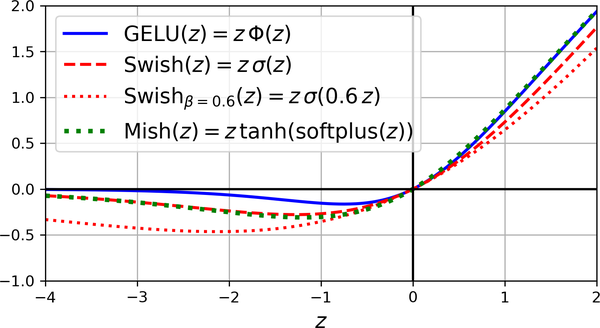
GELU outperforms every activation function discussed so far, but it is coputationaly expensive, so for easier tasks it is probably not worth it. Swish performs better still.

ReLU is a good default because it is easier to compute, and many libraries and hardware are optimized for it. But for more complex tasks, swish is a good default. Mish may give slightly better results, but requires more compute. To optimize for latency, leaky relu. 

## Batch Normalization
Batch normalization removes the need to scale or normalize inputs prior to training. It improves performance, and it allows for a higher learning rate, which means training completes in fewer epochs. It also acts as a regularizer, reducing the need for other regularization techniques.

It does make the model more complex, and there is a runtime penalty for predictions. 

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

2022-11-12 06:56:44.400045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [7]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [8]:
# normalize before activation remove activation from hidden layers and add as separate layers
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

### Gradient Clipping
Deal with exploding gradients by clipping them when they exceed a threshold

In [9]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
# model.compile([...], optimizer=optimizer)

## Reusing Pretrained Layers

In [10]:
# Replacing the output on a pre-trained model
#[...] # Assuming model A was already trained
# model_A = tf.keras.models.load_model("my_model_A")
#model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
#model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [11]:
# To avoid changing model A when you retrain the layers in model B, clone A before building
# model_A_clone = tf.keras.models.clone_model(model_A)
# model_A_clone.set_weights(model_A.get_weights())

In [12]:
# Because the new output is intialized randomly, it will make large errors. 
# Even if you plan to retrain the whole network layer, freeze all layers but output for
# the first few epochs, to reduce the size of the errors before you wreck your pretrained weights

#for later in model_B_on_A.layers[:-1]:
#    layer.trainable = False
    
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
#model_B_on_A. comile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# you must always compile the model after freezing or unfreezing layers

In [13]:
#history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
 #                         validation_data=(X_valid_B, y_valid_B))

#for layer in model_B_on_A.layers[:-1]:
 #   layer.trainable = True
    
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
#model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
#history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
 #                         validation_data=(X_valid_B, y_valid_B))

In [14]:
# Note, this is a toy example. Transfer learning does not work well with small dense netwroks. 
# Transfer Learning works best with deep CNNs that learn general feature detectors in early layers

### Unsupervised Pretraining
If you want to do a complex task and can't find a pretrained model, you can use unlabeled data you can train an autoencoder or a GAN, then reuse the lower layers, and add the output layer on top, and train with supervised learning.

### Pretraining on an Auxiliary Task
You can pretrain on an auxiliary task for which you can get a lot of training data, then reuse the lower layers.

For example, if you wanted to train a network to recoginize people, but only have a few examples of each individual, you could train a network on a bunch of photos, only saying whether or not they are the same person. 

## Faster Optimizers
- momentum - in Keras SGD has a momentum param. Breaks out of plateaus more quickly than SGD
- Nesterov Accelerated Gradient - set nesterov=True when using momentum. An optimzation on momentum
- AdaGrad - Accelerates simple problems, but tends to stop too early on deep neural networks
- Adam - Adaptive, with momentum. 
- AdaMax - can be more stable than Adam for some datasets, but generally Adam performs better
- Nadam - Adam with the Nesterov trick, converges slightly faster
- AdamW - Adam with weight decay, generalizes better than l2 regularization - tune weight decay hyperparameter.

Adaptive methods get to a good solution fast, but if your solution doesn't generalize well, try switching to NAG.

## Learning Rate Scheduling
exponential scheduling and 1cycle perform well. Power scheduling is easy to implement in keras

In [17]:
# decay is the hyper parameter for power scheduling
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [23]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)
# or
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** epoch / s
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [24]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
#history = model.fit(X_train, y_train, [...], callbacks=[lr_scheduler])

In [27]:
# schedule function can take current learning rate
def exponentail_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

# when you save a model, the leaarning rate is saved, but the epoch is not. 
# So if you want to resume training later, decaying based on the learning rate is better
# fit() does have an 'initial_epoch' argument, so you can work around this

In [29]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15: 
        return 0.005
    else:
        return 0.001

# Add ReduceLROnPlateau callback it multipleis LR by 0.5 when best validation doesn't improve for 5 consec epochs
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
#history = model.fit(X_train, y_train, [...], callbacks=[lr_scheduler])

In [34]:
# scheduled learning rate
import math

batch_size = 32
n_epochs = 25
#n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
#scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
#optimizer = tf.keras.optimizers.SGD(learning_rate=schedule_learning_rate)